# FuelProphet model

In [1]:
# Import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, date, time, timedelta

from sklearn.metrics import mean_squared_error,mean_absolute_error

import sys
import os
# Get the parent directory and add it to sys.path
parent_dir = os.path.abspath("..")
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from functions_nico.nico_fuelprophet import FuelProphet
from functions_laura.nico_fuelprophet_abs import FuelProphet_abs
from functions_nico.nico_preprocessing import load_data, merge_oil, merge_ex_rate, get_oil_euro
from functions_nico.nico_models import baseline_model, split_data, prophet_model
from functions_laura.Data_processing import resample_one_station

/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# MLFlow setup

In [2]:
import os
import mlflow

# Get absolute path for MLflow directory
mlflow_dir = os.path.abspath("../data/mlflow")

# Create fresh directory
os.makedirs(mlflow_dir, exist_ok=True)

# Basic MLflow config - use file protocol with absolute path 
mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

# Set up FuelProphet experiment
try:
    experiment_name = "FuelProphet_Nico_Loop_Abs_2"
    experiment = mlflow.get_experiment_by_name(experiment_name)
    
    if experiment is None:
        # Only create if it doesn't exist
        mlflow.create_experiment(experiment_name)
        
    # Set as active experiment
    mlflow.set_experiment(experiment_name)
    print("FuelProphet experiment setup successful!")
    
except Exception as e:
    print(f"MLflow error: {e}")

mlflow.keras.autolog(log_models=False)

Traceback (most recent call last):
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 347, in search_experiments
    exp = self._get_experiment(exp_id, view_type)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 445, in _get_experiment
    meta = FileStore._read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/tracking/file_store.py", line 1588, in _read_yaml
    return _read_helper(root, file_name, attempts_remaining=retries)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurabrylka/Documents/Git/FuelProphet/.venv/lib/python3.11/site-packages/mlflow/store/trac

FuelProphet experiment setup successful!


### adjusted print model function

In [3]:
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score

def print_model(real_data,predictions,x="datetime",y="e5",xlim=None,ylim=None,name="name",title=None,params=None):
    """Plots the real data and the predictions in one line plot

    Args:
        real_data (DataFrame): Includes the real time series data
        predictions (DataFrame): Includes model predictions
        x (str, optional): Name of the datetime variable. Defaults to "datetime".
        y (str, optional): Name of the prediction variable. Defaults to "e5".
        xlim (tuple, optional): Minimum and maximum limit of x-axis. Defaults to None.
        ylim (tuple, optional): Minimum and maximum limit of y-axis. Defaults to None.
        name (str, optional): Gas station name variable. Defaults to "name".
    """

    if params == None:
        params = {"background":"#f9fcfc",
                  "gridcolor": "#dcdbd9",
                  "legendedge": "#dcdbd9",
                  "legendface": "white",
                  "legendcol": "black",
                  "textcolor": "black"
                  }

    # Set figure size
    sns.set_theme(rc={'figure.figsize':(12,6)})

    # Set grid color
    sns.set_style("darkgrid", {"grid.color": params.get("gridcolor")})

    # Change border color of the figure (spines)
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_edgecolor(params.get("gridcolor"))

    
    
    # Dashed plot
    dash = sns.lineplot(data      = real_data[real_data[x] >= predictions[x].iloc[0]],
                 x         = "datetime",
                 y         = "e5",
                 color     = "#4281eaff",
                 drawstyle = 'steps-post',
                 #linestyle = "dashed",
                 linewidth = 3
                 )
    
    # Create line between train and test set
    plt.vlines(x         = predictions[x].iloc[0],
               ymin      = ylim[0],
               ymax      = ylim[1],
               color     = "#a6a5a4",
               linewidth = 2,
               linestyle = "dashed"
               )
    
    # Set transparency (alpha)
    for line in dash.lines:
        line.set_alpha(0.4)
    
    # Create lines
    real = sns.lineplot(data      = real_data[real_data[x] <= predictions[x].iloc[0]],
                 x         = "datetime",
                 y         = "e5",
                 color     = "#4281eaff",
                 drawstyle = 'steps-post',
                 label     = "Real price",
                 linewidth = 3
    )

    plt.vlines(x         = predictions[x].iloc[0],
               ymin      = real_data[real_data[x] == predictions[x].iloc[0]][y],
               ymax      = predictions[y].iloc[0],
               color     = "#f1881aff",
               linewidth = 3
               )
    
    sns.lineplot(data      = predictions,
                 x         = "datetime",
                 y         = "e5",
                 color     = "#f1881aff",
                 drawstyle = 'steps-post',
                 label     = "Predicted price",
                 linewidth = 3
                 )
    
    plt.text(predictions[x].iloc[0]+timedelta(minutes=40),ylim[0]+0.02,"Test →",fontweight="bold",fontsize=14,color="#a6a5a4")
    plt.text(predictions[x].iloc[0]-timedelta(minutes=360),ylim[0]+0.02,"← Train",fontweight="bold",fontsize=14,color="#a6a5a4")
    
    

    # Set limits
    if xlim != None:
        plt.xlim((pd.to_datetime(xlim[0]),pd.to_datetime(xlim[1])))
    if ylim != None:
        plt.ylim((ylim[0],ylim[1]))

    # Adapt title
    if title == None:
        plt.title("Fuel price prediction of " + real_data[name].iloc[1],fontweight="bold",fontsize=14,color=params.get("textcolor"))
    else:
        plt.title(title,fontweight="bold",fontsize=18,color=params.get("textcolor"))

    # Adapt labels
    plt.xlabel(" ",fontweight="bold",fontsize=16,color=params.get("textcolor"))
    plt.ylabel(y + " price (€/l)",fontweight="bold",fontsize=16,color=params.get("textcolor"))

    # Adapt xticks
    ax = plt.gca()
    xticks = ax.get_xticks()
    xticklabels = []
    for i, tick in enumerate(xticks):
        if i % 2 == 0:
            label = plt.matplotlib.dates.num2date(tick).strftime('%H:%M\n%d/%m/%Y')
        else:
            label = plt.matplotlib.dates.num2date(tick).strftime('%H:%M')
        xticklabels.append(label)
    ax.set_xticklabels(xticklabels)
    for label in plt.gca().get_xticklabels():
        label.set_fontsize(16)
        label.set_color(params.get("textcolor"))
        label.set_fontsize(16)

    # Adapt yticks
    for label in plt.gca().get_yticklabels():
        label.set_fontweight('normal')
        label.set_color(params.get("textcolor"))
        label.set_fontsize(16)

    # Adapt background color
    plt.gca().set_facecolor(params.get("background"))
    plt.gcf().set_facecolor(params.get("background"))

    # Create legend
    plt.legend(fontsize=16,loc='upper right', edgecolor=params.get("legendedge"), facecolor=params.get("legendface"), labelcolor = params.get("legendcol"),framealpha=1)
    plt.savefig("prediction.png")
    plt.show()

    rmse = round(np.sqrt(mean_squared_error(real_data[real_data[x].isin(predictions[x])][y],predictions[y])),3)
    mae = round(mean_absolute_error(real_data[real_data[x].isin(predictions[x])][y],predictions[y]),3)
    r2score = round(r2_score(real_data[real_data[x].isin(predictions[x])][y],predictions[y]),3)

    print("RMSE:", rmse)
    print("MAE:", mae)
    print("R2:", r2score)

    return rmse, mae, r2score


# Load Datasets

In [5]:
# Train
df01_train = pd.read_parquet('../data/parquet_4_testing_2/train_01.parquet')
df02_train = pd.read_parquet('../data/parquet_4_testing_2/train_02.parquet')
df03_train = pd.read_parquet('../data/parquet_4_testing_2/train_03.parquet')
df04_train = pd.read_parquet('../data/parquet_4_testing_2/train_04.parquet')
df05_train = pd.read_parquet('../data/parquet_4_testing_2/train_05.parquet')
df06_train = pd.read_parquet('../data/parquet_4_testing_2/train_06.parquet')
df07_train = pd.read_parquet('../data/parquet_4_testing_2/train_07.parquet')
df08_train = pd.read_parquet('../data/parquet_4_testing_2/train_08.parquet')
df09_train = pd.read_parquet('../data/parquet_4_testing_2/train_09.parquet')
df10_train = pd.read_parquet('../data/parquet_4_testing_2/train_10.parquet')
df11_train = pd.read_parquet('../data/parquet_4_testing_2/train_11.parquet')
df12_train = pd.read_parquet('../data/parquet_4_testing_2/train_12.parquet')
df13_train = pd.read_parquet('../data/parquet_4_testing_2/train_13.parquet')
df14_train = pd.read_parquet('../data/parquet_4_testing_2/train_14.parquet')
df15_train = pd.read_parquet('../data/parquet_4_testing_2/train_15.parquet')
df16_train = pd.read_parquet('../data/parquet_4_testing_2/train_16.parquet')
df17_train = pd.read_parquet('../data/parquet_4_testing_2/train_17.parquet')
df18_train = pd.read_parquet('../data/parquet_4_testing_2/train_18.parquet')
df19_train = pd.read_parquet('../data/parquet_4_testing_2/train_19.parquet')
df20_train = pd.read_parquet('../data/parquet_4_testing_2/train_20.parquet')
df21_train = pd.read_parquet('../data/parquet_4_testing_2/train_21.parquet')
df22_train = pd.read_parquet('../data/parquet_4_testing_2/train_22.parquet')
df23_train = pd.read_parquet('../data/parquet_4_testing_2/train_23.parquet')
df24_train = pd.read_parquet('../data/parquet_4_testing_2/train_24.parquet')
df25_train = pd.read_parquet('../data/parquet_4_testing_2/train_25.parquet')
df26_train = pd.read_parquet('../data/parquet_4_testing_2/train_26.parquet')
df27_train = pd.read_parquet('../data/parquet_4_testing_2/train_27.parquet')
df28_train = pd.read_parquet('../data/parquet_4_testing_2/train_28.parquet')
df29_train = pd.read_parquet('../data/parquet_4_testing_2/train_29.parquet')
df30_train = pd.read_parquet('../data/parquet_4_testing_2/train_30.parquet')

# Test
df01_test = pd.read_parquet('../data/parquet_4_testing_2/test_01.parquet')
df02_test = pd.read_parquet('../data/parquet_4_testing_2/test_02.parquet')
df03_test = pd.read_parquet('../data/parquet_4_testing_2/test_03.parquet')
df04_test = pd.read_parquet('../data/parquet_4_testing_2/test_04.parquet')
df05_test = pd.read_parquet('../data/parquet_4_testing_2/test_05.parquet')
df06_test = pd.read_parquet('../data/parquet_4_testing_2/test_06.parquet')
df07_test = pd.read_parquet('../data/parquet_4_testing_2/test_07.parquet')
df08_test = pd.read_parquet('../data/parquet_4_testing_2/test_08.parquet')
df09_test = pd.read_parquet('../data/parquet_4_testing_2/test_09.parquet')
df10_test = pd.read_parquet('../data/parquet_4_testing_2/test_10.parquet')
df11_test = pd.read_parquet('../data/parquet_4_testing_2/test_11.parquet')
df12_test = pd.read_parquet('../data/parquet_4_testing_2/test_12.parquet')
df13_test = pd.read_parquet('../data/parquet_4_testing_2/test_13.parquet')
df14_test = pd.read_parquet('../data/parquet_4_testing_2/test_14.parquet')
df15_test = pd.read_parquet('../data/parquet_4_testing_2/test_15.parquet')
df16_test = pd.read_parquet('../data/parquet_4_testing_2/test_16.parquet')
df17_test = pd.read_parquet('../data/parquet_4_testing_2/test_17.parquet')
df18_test = pd.read_parquet('../data/parquet_4_testing_2/test_18.parquet')
df19_test = pd.read_parquet('../data/parquet_4_testing_2/test_19.parquet')
df20_test = pd.read_parquet('../data/parquet_4_testing_2/test_20.parquet')
df21_test = pd.read_parquet('../data/parquet_4_testing_2/test_21.parquet')
df22_test = pd.read_parquet('../data/parquet_4_testing_2/test_22.parquet')
df23_test = pd.read_parquet('../data/parquet_4_testing_2/test_23.parquet')
df24_test = pd.read_parquet('../data/parquet_4_testing_2/test_24.parquet')
df25_test = pd.read_parquet('../data/parquet_4_testing_2/test_25.parquet')
df26_test = pd.read_parquet('../data/parquet_4_testing_2/test_26.parquet')
df27_test = pd.read_parquet('../data/parquet_4_testing_2/test_27.parquet')
df28_test = pd.read_parquet('../data/parquet_4_testing_2/test_28.parquet')
df29_test = pd.read_parquet('../data/parquet_4_testing_2/test_29.parquet')
df30_test = pd.read_parquet('../data/parquet_4_testing_2/test_30.parquet')

In [6]:
# Train
df01_train.rename(columns={"date": "datetime"}, inplace=True)
df02_train.rename(columns={"date": "datetime"}, inplace=True)
df03_train.rename(columns={"date": "datetime"}, inplace=True)
df04_train.rename(columns={"date": "datetime"}, inplace=True)
df05_train.rename(columns={"date": "datetime"}, inplace=True)
df06_train.rename(columns={"date": "datetime"}, inplace=True)
df07_train.rename(columns={"date": "datetime"}, inplace=True)
df08_train.rename(columns={"date": "datetime"}, inplace=True)
df09_train.rename(columns={"date": "datetime"}, inplace=True)
df10_train.rename(columns={"date": "datetime"}, inplace=True)
df11_train.rename(columns={"date": "datetime"}, inplace=True)
df12_train.rename(columns={"date": "datetime"}, inplace=True)
df13_train.rename(columns={"date": "datetime"}, inplace=True)
df14_train.rename(columns={"date": "datetime"}, inplace=True)
df15_train.rename(columns={"date": "datetime"}, inplace=True)
df16_train.rename(columns={"date": "datetime"}, inplace=True)
df17_train.rename(columns={"date": "datetime"}, inplace=True)
df18_train.rename(columns={"date": "datetime"}, inplace=True)
df19_train.rename(columns={"date": "datetime"}, inplace=True)
df20_train.rename(columns={"date": "datetime"}, inplace=True)
df21_train.rename(columns={"date": "datetime"}, inplace=True)
df22_train.rename(columns={"date": "datetime"}, inplace=True)
df23_train.rename(columns={"date": "datetime"}, inplace=True)
df24_train.rename(columns={"date": "datetime"}, inplace=True)
df25_train.rename(columns={"date": "datetime"}, inplace=True)
df26_train.rename(columns={"date": "datetime"}, inplace=True)
df27_train.rename(columns={"date": "datetime"}, inplace=True)
df28_train.rename(columns={"date": "datetime"}, inplace=True)
df29_train.rename(columns={"date": "datetime"}, inplace=True)
df30_train.rename(columns={"date": "datetime"}, inplace=True)


# Test
df01_test.rename(columns={"date": "datetime"}, inplace=True)
df02_test.rename(columns={"date": "datetime"}, inplace=True) 
df03_test.rename(columns={"date": "datetime"}, inplace=True) 
df04_test.rename(columns={"date": "datetime"}, inplace=True) 
df05_test.rename(columns={"date": "datetime"}, inplace=True) 
df06_test.rename(columns={"date": "datetime"}, inplace=True) 
df07_test.rename(columns={"date": "datetime"}, inplace=True) 
df08_test.rename(columns={"date": "datetime"}, inplace=True) 
df09_test.rename(columns={"date": "datetime"}, inplace=True) 
df10_test.rename(columns={"date": "datetime"}, inplace=True) 
df11_test.rename(columns={"date": "datetime"}, inplace=True) 
df12_test.rename(columns={"date": "datetime"}, inplace=True) 
df13_test.rename(columns={"date": "datetime"}, inplace=True) 
df14_test.rename(columns={"date": "datetime"}, inplace=True) 
df15_test.rename(columns={"date": "datetime"}, inplace=True) 
df16_test.rename(columns={"date": "datetime"}, inplace=True) 
df17_test.rename(columns={"date": "datetime"}, inplace=True) 
df18_test.rename(columns={"date": "datetime"}, inplace=True) 
df19_test.rename(columns={"date": "datetime"}, inplace=True) 
df20_test.rename(columns={"date": "datetime"}, inplace=True) 
df21_test.rename(columns={"date": "datetime"}, inplace=True) 
df22_test.rename(columns={"date": "datetime"}, inplace=True) 
df23_test.rename(columns={"date": "datetime"}, inplace=True) 
df24_test.rename(columns={"date": "datetime"}, inplace=True) 
df25_test.rename(columns={"date": "datetime"}, inplace=True) 
df26_test.rename(columns={"date": "datetime"}, inplace=True) 
df27_test.rename(columns={"date": "datetime"}, inplace=True) 
df28_test.rename(columns={"date": "datetime"}, inplace=True) 
df29_test.rename(columns={"date": "datetime"}, inplace=True) 
df30_test.rename(columns={"date": "datetime"}, inplace=True) 

# Fit Model

In [7]:
datasets = {
    'df01': (df01_train, df01_test),
    'df02': (df02_train, df02_test),
    'df03': (df03_train, df03_test),
    'df04': (df04_train, df04_test),
    'df05': (df05_train, df05_test),
    'df06': (df06_train, df06_test),
    'df07': (df07_train, df07_test),
    'df08': (df08_train, df08_test),
    'df09': (df09_train, df09_test),
    'df10': (df10_train, df10_test),
    'df11': (df11_train, df11_test),
    'df12': (df12_train, df12_test),
    'df13': (df13_train, df13_test),
    'df14': (df14_train, df14_test),
    'df15': (df15_train, df15_test),
    'df16': (df16_train, df16_test),
    'df17': (df17_train, df17_test),
    'df18': (df18_train, df18_test),
    'df19': (df19_train, df19_test),
    'df20': (df20_train, df20_test),
    'df21': (df21_train, df21_test),
    'df22': (df22_train, df22_test),
    'df23': (df23_train, df23_test),
    'df24': (df24_train, df24_test),
    'df25': (df25_train, df25_test),
    'df26': (df26_train, df26_test),
    'df27': (df27_train, df27_test),
    'df28': (df28_train, df28_test),
    'df29': (df29_train, df29_test),
    'df30': (df30_train, df30_test)
}


Processing dataset: df01
[0.41778779 0.08892871 0.26341347 0.13610676 0.09376327]
[  -1  -36 -288 -576 -864]


/var/folders/tk/dk9lmvjd3q33k1whr558my540000gn/T/ipykernel_99587/22393562.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


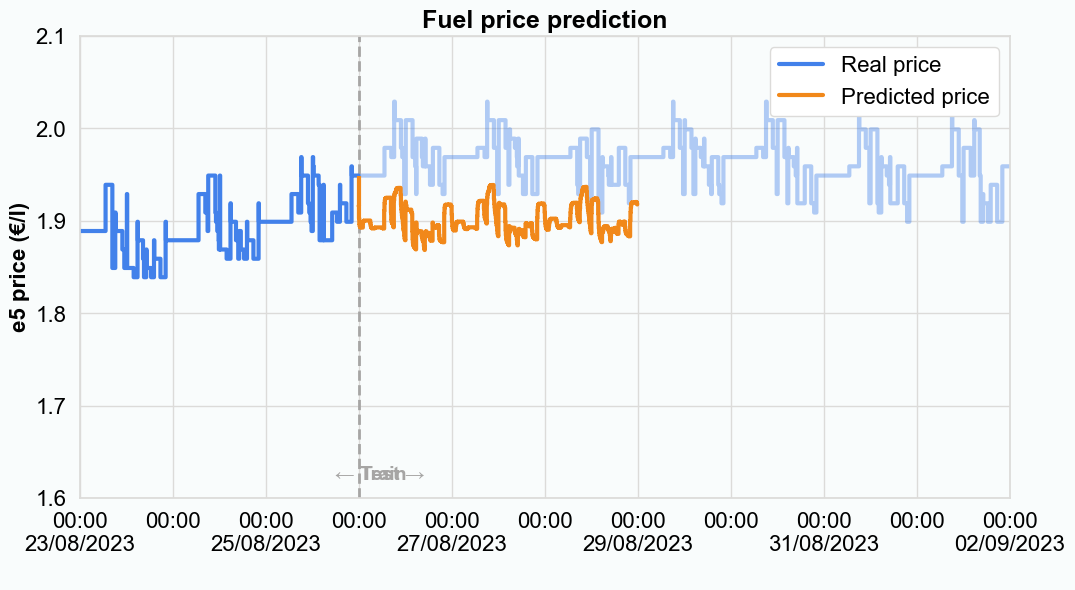

RMSE: 0.069
MAE: 0.067
R2: -8.43
Error in df01: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

Processing dataset: df02


KeyboardInterrupt: 

In [8]:
# Create an error log dictionary
error_log = {}

# LOOP
for dataset_name, (train, test) in datasets.items():
    print(f"\nProcessing dataset: {dataset_name}")
    
    try:
        mlflow.end_run()
        
        with mlflow.start_run(run_name=f"fuel_model_Nico_{dataset_name}") as run:
            mlflow.set_tag("dataset", f'{dataset_name}')

            df = pd.concat([train, test], ignore_index=True)

            features = [-1,-2,-3,-4,-5,-288,-(7*288)]
            b0 = np.array([0.15,0.08,0.06,0.04,0.02,0.55,0.1]) # Can be randomly chosen. Is useless if model.fit_pacf is used
    
            model = FuelProphet_abs(b0=b0,features=features) # model = FuelProphet(b0=b0,features=features)
            model.fit_pacf(train,threshold=0.2)
            model.normalize()
            pred = model.predict(X=train,num_predictions=(3*288)) # (3*288) len(test)
            print(model.b)
            print(model.features)


            xmin = pred['datetime'].iloc[0] - pd.Timedelta(days=3)
            xmax = test['datetime'].max()

            rmse, mae, r2score = print_model(df, pred, xlim=(xmin, xmax), ylim=(1.60, 2.10), title="Fuel price prediction")
            mlflow.log_artifact("prediction.png")
            mlflow.log_artifact("Features", model.features)
            mlflow.log_artifact("Weights", model.b)
            mlflow.log_metric("RMSE", rmse)
            mlflow.log_metric("MAE", mae)
            mlflow.log_metric("R2_score", r2score)

            print(f"Successfully processed {dataset_name}")
        
    except Exception as e:
        # Log the error and continue with next dataset
        error_message = f"Error in {dataset_name}: {str(e)}"
        error_log[dataset_name] = error_message
        print(error_message)
        
        # Make sure to end the MLflow run if it failed
        mlflow.end_run()
        continue

# After the loop, print summary of errors
print("\n=== Error Summary ===")
if error_log:
    print(f"Total errors: {len(error_log)}")
    for dataset, error in error_log.items():
        print(f"\n{dataset}:")
        print(error)
else:
    print("All datasets processed successfully!")

In [16]:
mlflow.end_run()


=== Error Summary ===
Total errors: 30

df06:
Error in df06: Found input variables with inconsistent numbers of samples: [554, 864]

In [ ]:
#Check data:

%mlflow ui --backend-store-uri file:data/mlflow